In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import torch

# Overlay Mesh Graph on UK Map

In [4]:
proj = ccrs.PlateCarree()

In [5]:
def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
      
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=proj)
        ax.text(lon + 0.1, lat + 0.1, city, transform=proj)
        
def bounding_box(ax, box):
    lon_min, lon_max, lat_min, lat_max = box
    top_left = [lon_min, lat_max]
    top_right = [lon_max, lat_max]
    bottom_left = [lon_min, lat_min]
    bottom_right = [lon_max, lat_min]
    
    corners = [
        bottom_left,
        top_left,
        top_right,
        bottom_right,
        bottom_left,
    ]
    
    lons, lats = zip(*corners)
    
    ax.plot(
        lons, lats,
        "r-", 
        transform=proj
    )
    

def grid_points(ax, grid_xy):
    ax.plot(grid_xy[0], grid_xy[1], 'ro', transform=proj, markersize=1)

def mesh_points(ax, mesh_pos, mesh_node_levels=None, filter_level=None):
    color_map = {
        0: 'blue',
        1: 'green',
        2: 'red',
        3: 'cyan',
        4: 'magenta',
        5: 'yellow',
        6: 'black'
    }
    if mesh_node_levels:
        for i in range(len(mesh_pos[0])):
            if filter_level and mesh_node_levels[i] != filter_level:
                continue
            node_color = color_map[mesh_node_levels[i]]
            ax.plot(mesh_pos[0][i], mesh_pos[1][i], 'o', color=node_color, transform=proj, markersize=3)
    else:
        ax.plot(mesh_pos[0], mesh_pos[1], 'go', transform=proj, markersize=3)

def m2m_edges(ax, mesh_pos, m2m_edge_set):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set, mesh_node_levels=None, filter_mesh_level=None): 
    for edge in g2m_edge_set:
        if mesh_node_levels and filter_mesh_level and mesh_node_levels[edge[1]] != filter_mesh_level:
            continue
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=proj,
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=proj,
            linewidth=0.5
        )
        
def degrees(edge_index):
    degrees = [0] * (max(edge_index[0]) + 1)
    for i in range(edge_index.shape[1]):
        degrees[edge_index[0, i]] += 1
        
    return max(degrees), min(degrees)

## Load datas

In [20]:
# Load dataset and graph
# dir = "./data/new_era5_uk/static/nwp_xy.npy"
# graph_name = "new_graphcast"

# dir = "./data/era5_uk/static/nwp_xy.npy"
# graph_name = "uk_graphcast"

# dir = "./data/era5_global/static/nwp_xy.npy"
# graph_name = "global_graphcast"

# dir = "./data/era5_uk_big/static/nwp_xy.npy"
# graph_name = "uk_big_graphcast"

# dir = "./data/era5_uk_big/static/nwp_xy.npy"
# graph_name = "test_uk_big_graphcast"

# dir = "./data/era5_global/static/nwp_xy.npy"
# graph_name = "test_global_graphcast"

# dir = "./data/era5_uk/static/nwp_xy.npy"
# graph_name = "rect_era5_uk"

# dir = "./data/era5_uk_big/static/nwp_xy.npy"
# graph_name = "uk_big_ico"

# dir = "./data/era5_uk/static/nwp_xy.npy"
# graph_name = "uk_ico"

dir = "./data/era5_uk_small/static/nwp_xy.npy"
graph_name = "uk_small_ico"

graph_dir_path = os.path.join("graphs", graph_name)

In [21]:
# Load grid
grid_xy = np.load(dir)
print(grid_xy.shape)
grid_xy = grid_xy.reshape(2, -1)

# Load mesh nodes
mesh_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt")).T # (2, n_mesh)
mesh_pos = mesh_pos[[0, 1]]
m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))[0]
edge_set = {tuple(sorted(e)) for e in m2m_edge_index.T}

g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))
g2m_edge_set = sorted(list({tuple(e) for e in g2m_edge_index.T}))

m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))
m2g_edge_set = sorted(list({tuple(e) for e in m2g_edge_index.T}))

mesh_node_levels = torch.load(os.path.join(graph_dir_path, "mesh_node_levels.pt"))

(2, 46, 40)


In [22]:
mesh_pos.shape

torch.Size([2, 79])

In [23]:
len(mesh_node_levels)

79

## Multi-layer mesh

In [24]:
mesh_levels = {}
src, dst = m2m_edge_index
for u, v in zip(src, dst):
    u_level, v_level = mesh_node_levels[u], mesh_node_levels[v]
    if u_level >= v_level:
        if u_level not in mesh_levels:
            mesh_levels[u_level] = set()
        mesh_levels[u_level].add(tuple(sorted([u, v])))

In [25]:
mesh_levels = {k: list(v) for k, v in mesh_levels.items()}

In [26]:
a, b = mesh_pos
[a.min(), a.max(), b.min(), b.max()]

[tensor(-9.3587), tensor(2.8687), tensor(49.4385), tensor(61.2733)]

In [27]:
print("Verify g2m connectivity")
print("Grid Nodes min, max: ", g2m_edge_index[0].min(), g2m_edge_index[0].max())
print("Mesh nodes min, max: ", g2m_edge_index[1].min(), g2m_edge_index[1].max())
print("Grid Nodes unique:", g2m_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", g2m_edge_index[1].unique().shape[0])

Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(1839)
Mesh nodes min, max:  tensor(0) tensor(78)
Grid Nodes unique: 1840
Mesh nodes unique: 79


In [28]:
print("Verify m2g connectivity")
print("Grid Nodes min, max: ", m2g_edge_index[0].min(), m2g_edge_index[0].max())
print("Mesh nodes min, max: ", m2g_edge_index[1].min(), m2g_edge_index[1].max())
print("Grid Nodes unique:", m2g_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", m2g_edge_index[1].unique().shape[0])

Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(78)
Mesh nodes min, max:  tensor(0) tensor(1839)
Grid Nodes unique: 79
Mesh nodes unique: 1840


In [29]:
lon, lat = grid_xy
grid_extent = [lon.min(), lon.max(), lat.min(), lat.max()]
grid_extent

[-8.0, 1.75, 49.75, 61.0]

Map Bounding box:
[-8.0, 1.75, 49.75, 61.0]
UK Settlements Bounding box:
[-8.0, 1.75, 49.75, 61.0]


Text(0.5, 1.0, 'ERA5 UK - GraphCast')

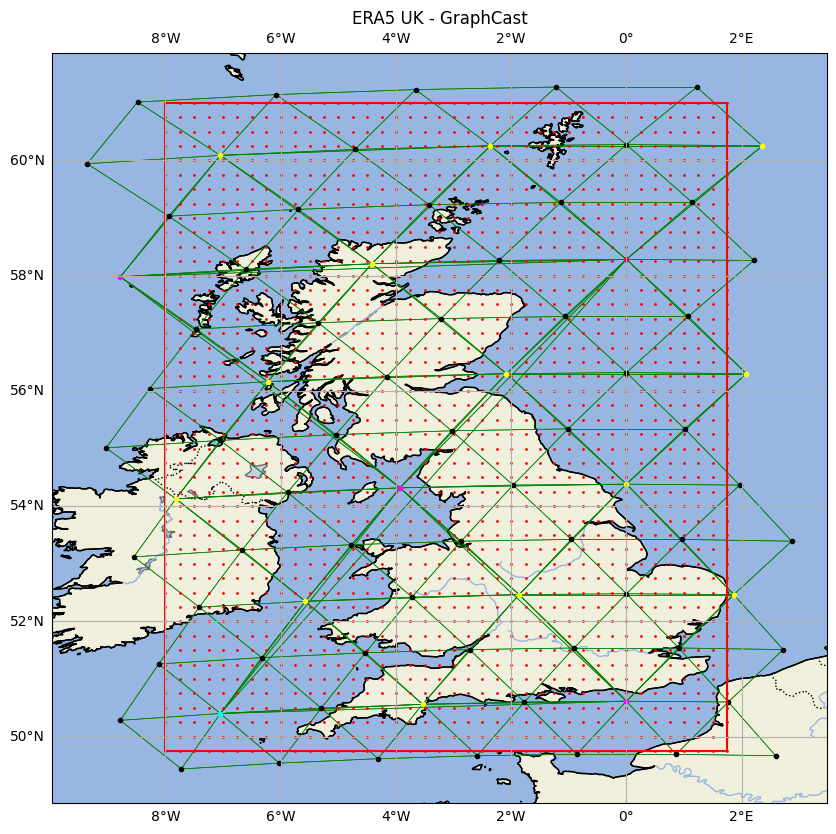

In [30]:
# Create a map with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

# Set the extent to focus on the UK
lon, lat = grid_xy
uk_extent = [lon.min(), lon.max(), lat.min(), lat.max()]
print("Map Bounding box:")
print(uk_extent)

# Add geographical features
add_geo_features(ax)

# Add cities
# cities = {
#     'London': (-0.1276, 51.5074),
#     'Edinburgh': (-3.1883, 55.9533),
#     'Cardiff': (-3.1791, 51.4816),
#     'Belfast': (-5.9301, 54.5973)
# }
# add_cities(ax, cities)

# Add m2m edges
# m2m_edges(ax, mesh_pos, mesh_levels[5])
m2m_edges(ax, mesh_pos, edge_set)


# Add g2m edges
# g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set, mesh_node_levels=mesh_node_levels, filter_mesh_level=5)
# g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set)

# Add m2g edges
# m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set)

# Add grid nodes
grid_points(ax, grid_xy)

# Add mesh nodes
mesh_points(ax, mesh_pos, mesh_node_levels)
# mesh_points(ax, mesh_pos, mesh_node_levels, 5)
# mesh_points(ax, mesh_pos)

# small_uk = [-14.015517, 2.0919117, 49.674, 61.061]
# small_uk = [-13.0, 7.0, 45.0, 65.0]
# print("UK Bounding box:")
# print(small_uk)
# print(small_uk[1] - small_uk[0], small_uk[3] - small_uk[2])
# bounding_box(ax, small_uk)

uk_settlments = [-8.00, 1.75, 49.75, 61.00]
print("UK Settlements Bounding box:")
print(uk_settlments)
bounding_box(ax, uk_settlments)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_lables = False
gl.right_labels = False

plt.title('ERA5 UK - GraphCast')

In [45]:
# import networkx as nx
import dgl

/vol/bitbucket/bet20/nlam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
data_dict = {
    ("mesh", "m2m", "mesh"): (m2m_edge_index[0], m2m_edge_index[1]),
    ("grid", "g2m", "mesh"): (g2m_edge_index[0], g2m_edge_index[1]),
}

N_mesh = mesh_pos.shape[1]
N_grid = grid_xy.shape[1]
num_nodes_dict = {"mesh": N_mesh, "grid": N_grid}

G = dgl.heterograph(data_dict, num_nodes_dict)
G.nodes["mesh"].data["pos"] = mesh_pos.T
G.nodes["grid"].data["pos"] = grid_xy.T

AttributeError: 'numpy.ndarray' object has no attribute 'device'